In [148]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [149]:
block_size = 5
n_embd = 20
hidden_size = 30
batch_size = 32

In [150]:
data = open("names.txt", "r").read()

In [ ]:
chars = sorted(list(set(data)))
chars[0] = "."
vocab_size = len(chars)

stoi = { s : i for i, s in enumerate(chars)}
itos = { i : s for i, s in enumerate(chars)}

In [153]:
def make_pairs(data):
    names = data.splitlines()
    X, y = [], []
    
    for name in names:
        word = name + "."
        cur = ["."] * block_size

        for w in word:
            X.append([stoi[i] for i in cur])
            y.append([stoi[w]])

            cur.append(w)
            cur.pop(0)
    return np.array(X), np.array(y).reshape(-1, )

In [154]:
X, y = make_pairs(data)
X.shape, y.shape

((228146, 5), (228146,))

In [ ]:
# visualize data
for j in range(10):
    print("".join([ itos[i] for i in X[j]]),  itos[y[j]])

..... e
....e m
...em m
..emm a
.emma .
..... o
....o l
...ol i
..oli v
.oliv i


In [156]:
class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.embeddings = np.random.randn(vocab_size, n_embd) 
    
    def forward(self, X):
        self.prev = X  # (batch_size, seq_length)
        return self.embeddings[X].reshape(X.shape[0], -1) # (batch_size, seq_length * n_embd)
    
    def backward(self, grad, lr):
        batch_size, seq_length = grad.shape
        seq_length = seq_length // self.n_embd

        grad = grad.reshape(batch_size, seq_length, self.n_embd)
        flat_indices = self.prev.flatten()
        flat_grad = grad.reshape(-1, self.n_embd)

        #for i in range(len(flat_indices)):
        #    self.embeddings[flat_indices[i]] -= lr * flat_grad[i]  this is what happens below

        np.add.at(self.embeddings, flat_indices, -lr * flat_grad) 
    
    def __call__(self, indices):
        return self.forward(indices)
    

class Linear:
    def __init__(self, in_feats, out_feats):
        self.w = np.random.randn(in_feats, out_feats) / np.sqrt(in_feats)
        self.b = np.zeros((1, out_feats))
    
    def forward(self, X):
        self.X = X
        out = X @ self.w + self.b
        return out
    
    def backward(self, grad, lr):
        n_grad = grad @ self.w.T # (batch, out_feat) @ (out_feat, in_feat) = (batch, in_feat)
        self.w -= self.X.T @ grad * lr / self.X.shape[0] # (in_feat, batch) @ (batch, out_feat) = (in_feat, out_feat)
        self.b -= np.sum(grad, axis=0) * lr / self.X.shape[0]
        return n_grad
    
    def __call__(self, X):
        return self.forward(X)
    

class Tanh:
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out

    def backward(self, grad, lr):
        return grad * (1 - self.out ** 2)
    
    def __call__(self, X):
        return self.forward(X)
    
    
class ReLU:
    def forward(self, X):
        self.X = X  # Store input for backward pass
        return np.maximum(0, X)  # ReLU function: max(0, x)

    def backward(self, grad, lr):
        return grad * (self.X > 0)  # Gradient is 1 where X > 0, else 0

    def __call__(self, X):
        return self.forward(X)

In [157]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(pred, target):

    batch_size = pred.shape[0]
    probs = softmax(pred)  

    grad = probs.copy()
    grad[np.arange(batch_size), target] -= 1  
    grad /= batch_size  

    log_probs = np.log(np.clip(probs[np.arange(batch_size), target], 1e-12, 1.0))  
    loss = -np.mean(log_probs)

    return loss, grad

In [158]:
model = [
    Embedding(vocab_size, n_embd),
    Linear(block_size * n_embd, hidden_size),
    Tanh(),
    Linear(hidden_size, vocab_size)
]

In [159]:
losses = []
lr = 0.01

for step in range(1000000):

    ix = np.random.randint(0, X.shape[0], size=(batch_size,) )
    X_batch = X[ix]
    y_batch = y[ix]

    for layer in model:
        X_batch = layer(X_batch)
    
    loss, grad = cross_entropy_loss(X_batch, y_batch)

    for layer in model[::-1]:
        grad = layer.backward(grad, lr)
    
    if step%10000 == 0:
        print(f"Step: {step}   Loss: {loss}")

    if step%100000 == 0:
        lr *= 0.93
    losses.append(np.log10(loss))

Step: 0   Loss: 3.4682958550539316
Step: 10000   Loss: 3.297767636069662
Step: 20000   Loss: 2.3901727042562317
Step: 30000   Loss: 2.679329332023403
Step: 40000   Loss: 2.184394885443627
Step: 50000   Loss: 2.52162776788046
Step: 60000   Loss: 2.1589075383249745
Step: 70000   Loss: 2.780126753722661
Step: 80000   Loss: 2.1649242830118594
Step: 90000   Loss: 2.160716560903573
Step: 100000   Loss: 2.6364093065306715
Step: 110000   Loss: 2.574769976487012
Step: 120000   Loss: 2.5640553497877896
Step: 130000   Loss: 2.320806997743526
Step: 140000   Loss: 2.361844958769736
Step: 150000   Loss: 2.15277627587974
Step: 160000   Loss: 2.395325466166642
Step: 170000   Loss: 2.4578616495249763
Step: 180000   Loss: 2.4484114573369515
Step: 190000   Loss: 2.1829883292607297
Step: 200000   Loss: 2.5590520328992197
Step: 210000   Loss: 2.0157361912221976
Step: 220000   Loss: 1.9684200538207395
Step: 230000   Loss: 2.4614508901689764
Step: 240000   Loss: 2.1595493470290723
Step: 250000   Loss: 2.4364

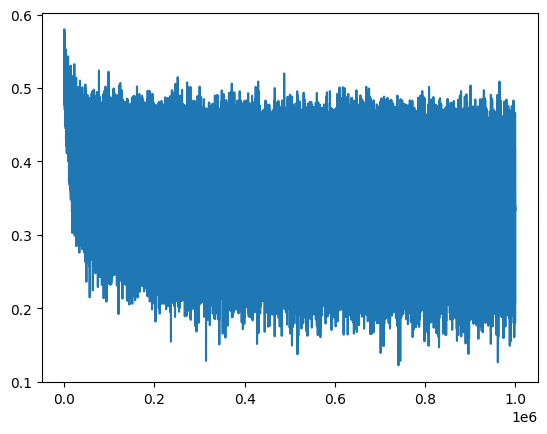

In [160]:
plt.plot(losses)

In [193]:
for _ in range(20):
    names = []
    context = [0] * (block_size)
    while True:
        out = np.array(context).reshape(1, block_size)

        for layer in model:
            out = layer(out)

        probs = softmax(out).reshape(-1)
        ix = np.random.multinomial(1, probs)
        ix = np.argmax(ix)
        context = context[1:] + [ix]
        names.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in names))

amamy.
kanshak.
rovan.
fidan.
kalani.
ahciy.
arrak.
ersla.
kilann.
saine.
mey.
lamkerlee.
sosrij.
rafmy.
are.
shalon.
zyici.
jeyma.
briston.
marria.
